In [2]:
import os
import deeplabcut
import numpy as np
import glob as glob
import pandas as pd
import dlc2kinematics
from pathlib import Path
from scipy.io import loadmat
from natsort import natsorted
import matplotlib.pyplot as plt

C:\ProgramData\Anaconda3\envs\DEEPLABCUT\lib\site-packages\statsmodels\compat\pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex
C:\ProgramData\Anaconda3\envs\DEEPLABCUT\lib\site-packages\deeplabcut\__init__.py:78: UserWarning: 
        As PyTorch is not installed, unsupervised identity learning will not be available.
        Please run `pip install torch`, or ignore this warning.
        
  warnings.warn(


# FUNCTIONS

In [18]:
# Extract folders for each dataset
def extract_folders(anipose_folders_path, ballpos_folders_path, ballvel_folders_path, SC_path, exception):
    # extract folders with 3d position data
    pos_folders = []
    for i in anipose_folders_path.glob('*\\pose-3d\\*.csv'):
        if len(exception) != 0:
            if str(i).split("\\")[-3] in exception:
                continue
            else:    
                pos_folders.append(i)
        else:
            pos_folders.append(i)

    pos_folders = natsorted(pos_folders)
    
    # extract folders with angle data
    angle_folders = []
    for i in anipose_folders_path.glob('*\\angles\\*.csv'):
        if len(exception) != 0:
            if str(i).split("\\")[-3] in exception:
                continue
            else:    
                angle_folders.append(i)
        else:
            angle_folders.append(i)

    angle_folders = natsorted(angle_folders)
    
    # extract folders with ball position data
    ballpos_folders = []
    for i in ballpos_folders_path.glob('*.csv'):
        if len(exception) != 0:
            if str(i).split("\\")[-1][:2] in exception:
                continue
            else:    
                ballpos_folders.append(i)
        else:
            ballpos_folders.append(i)

    ballpos_folders = natsorted(ballpos_folders)
    
    # extract folders with ball velocity data
    ballvel_folders = []
    for i in ballvel_folders_path.glob('*.csv'):
        if len(exception) != 0:
            if str(i).split("\\")[-1][:2] in exception:
                continue
            else:    
                ballvel_folders.append(i)
        else:
            ballvel_folders.append(i)

    ballvel_folders = natsorted(ballvel_folders)
    
    # extract folders with sc predictions
    sc_folders = []
    for i in SC_path.glob('*.csv'):
        if len(exception) != 0:
            if str(i).split("\\")[-1][:2] in exception:
                continue
            else:    
                sc_folders.append(i)
        else:
            sc_folders.append(i)

    sc_folders = natsorted(sc_folders)
    
    return pos_folders, angle_folders, ballpos_folders, ballvel_folders, sc_folders

In [13]:
# extract position, angle, ball velocity, and swing/stance data
def extract_data(pos_folders, angle_folders, ballpos_folders, ballvel_folders):
    pos3d_df = pd.DataFrame()

    for data_csv in pos_folders:
        temp_csv = pd.read_csv(data_csv)
        pos3d_df = pd.concat([pos3d_df, temp_csv], axis=0, ignore_index=True)

    # remove extra columns
    pos3d_df = pos3d_df.iloc[:, :-13]
    pos3dclean_df = pd.DataFrame()
    for item in np.arange(0,len(pos3d_df.columns),6):
        pos3dclean_df = pd.concat([pos3dclean_df, pos3d_df.iloc[:,item:item+3]],axis=1)  
    pos3d_df = pos3dclean_df
    pos3d_df.reset_index(drop=True, inplace=True)
    
    angle_df = pd.DataFrame()

    for data_csv in angle_folders:
        temp_csv = pd.read_csv(data_csv)
        angle_df = pd.concat([angle_df, temp_csv], axis=0, ignore_index=True)

    angle_df = angle_df.iloc[:, :-1]
    angle_df.reset_index(drop=True, inplace=True)
    
    ballpos_df = pd.DataFrame()

    for data_csv in ballpos_folders:
        temp_csv = pd.read_csv(data_csv)
        ballpos_df = pd.concat([ballpos_df, temp_csv], axis=0, ignore_index=True)

    ballpos_df.columns = ["x_pos", "y_pos", "z_pos"]
    ballpos_df.reset_index(drop=True, inplace=True)
    
    ballvel_df = pd.DataFrame()

    for data_csv in ballvel_folders:
        temp_csv = pd.read_csv(data_csv)
        ballvel_df = pd.concat([ballvel_df, temp_csv], axis=0, ignore_index=True)

    ballvel_df.columns = ["x_vel", "y_vel", "z_vel"]
    ballvel_df.reset_index(drop=True, inplace=True)
    
    # swing/stance
    
    return pos3d_df, angle_df, ballpos_df, ballvel_df

In [14]:
# extract information about fly number, trial number, frame number, and stimulation frequency
def extract_initcol(pos_folders, angle_folders, ballpos_folders, ballvel_folders, sc_folders, SF_path):
    # fly number
    flynum = []
    for data_csv in pos_folders:
        num = int(str(data_csv).split("\\")[-3][1:])
        temp_csv = pd.read_csv(data_csv)
        flynum = flynum + [num]*len(temp_csv)

    flynum_df = pd.DataFrame(flynum)
    flynum_df.reset_index(drop=True, inplace=True)
    flynum_df.columns = ["flynum"]
    
    # trial number
    tnum = []
    tlen = 1400
    for data_csv in pos_folders:
        temp_csv = pd.read_csv(data_csv)
        fnum = temp_csv['fnum']

        count = 1
        for i in range(int(len(temp_csv)/tlen)):
            tnum = tnum + [count]*tlen
            count += 1

    tnum_df = pd.DataFrame(tnum)
    tnum_df.reset_index(drop=True, inplace=True)
    tnum_df.columns = ["tnum"]
    
    # frame number
    fnum = []
    for data_csv in pos_folders:
        temp_csv = pd.read_csv(data_csv)
        fnumraw = temp_csv['fnum']

        fnum = fnum+list(fnumraw)

    fnum_df = pd.DataFrame(fnum)
    fnum_df.reset_index(drop=True, inplace=True)
    fnum_df.columns = ["fnum"]
    
    # stimulation frequency
    SFraw_df = pd.read_csv(SF_path)
    SF = []
    for data_csv in pos_folders:
        temp_csv = pd.read_csv(data_csv)
        num = str(data_csv).split("\\")[-3]

        count = 0
        for i in range(int(len(temp_csv)/tlen)):
            SFcurrfly = list(SFraw_df[num])
            SF = SF + [SFcurrfly[count]]*tlen
            count+=1

    SF_df = pd.DataFrame(SF)
    SF_df.reset_index(drop=True, inplace=True)
    SF_df.columns = ["SF"]
    
    #step cycle
    for data_csv in sc_folders:
        temp_csv = pd.read_csv(data_csv)
        SC_df = temp_csv.iloc[:, 1:]
    
    return flynum_df, tnum_df, fnum_df, SF_df, SC_df

In [19]:
def combine_flydata(anipose_folders_path, ballpos_folders_path, ballvel_folders_path, SF_path, SC_path, exception):
    
    pos_folders, angle_folders, ballpos_folders, ballvel_folders, sc_folders = extract_folders(anipose_folders_path, ballpos_folders_path, ballvel_folders_path, SC_path, exception)
    pos3d_df, angle_df, ballpos_df, ballvel_df = extract_data(pos_folders, angle_folders, ballpos_folders, ballvel_folders)
    flynum_df, tnum_df, fnum_df, SF_df, SC_df = extract_initcol(pos_folders, angle_folders, ballpos_folders, ballvel_folders, sc_folders, SF_path)
    
    fly_data = pd.concat([flynum_df, tnum_df, fnum_df, SF_df, pos3d_df, angle_df, ballpos_df, ballvel_df, SC_df], axis=1)
    return fly_data

In [20]:
def generate_table(all_data):
    gen_df = pd.DataFrame()
    for genotype in all_data.keys():
        fly_data = all_data[genotype]
        gendata = {"Genotype": genotype, "no. of flies": [max(fly_data["flynum"])], "flydata": [fly_data]}
        temp_df = pd.DataFrame(data=gendata)
        gen_df = pd.concat([gen_df, temp_df], axis=0)
    return gen_df

# GENERATE DATASET

## Define genotypes

In [22]:
# BPN
BPN_anipose_folders_path = Path(r'\\mpfi.org\public\sb-lab\BallSystem_AniposeReconstructions\3_BPN-S1-Activation\project')
BPN_ballpos_folders_path = Path(r'\\mpfi.org\public\sb-lab\BallSystem_RawData\19_UAS-CSChrim-BPN-S1\Set1_HighInt_0.35\FlyTrajectories')
BPN_ballvel_folders_path = Path(r'\\mpfi.org\public\sb-lab\BallSystem_RawData\19_UAS-CSChrim-BPN-S1\Set1_HighInt_0.35\BallTracking')
BPN_SF_path = Path(r'\\mpfi.org\public\sb-lab\BallSystem_AniposeReconstructions\3_BPN-S1-Activation\BPN-S1_Metadata_Freq.csv')
BPN_SC_path = Path(r'\\mpfi.org\public\sb-lab\BallSystem_AniposeReconstructions\3_BPN-S1-Activation\Step_cycle\SC')
BPN_exception = ["N9"] # flies to skip over
BPN_data = combine_flydata(BPN_anipose_folders_path, BPN_ballpos_folders_path, BPN_ballvel_folders_path, BPN_SF_path, BPN_SC_path, BPN_exception)

# P9 LT
P9LT_anipose_folders_path = Path(r'\\mpfi.org\public\sb-lab\BallSystem_AniposeReconstructions\4_P9-LeftTurning\project')
P9LT_ballpos_folders_path = Path(r'\\mpfi.org\public\sb-lab\BallSystem_RawData\20_P9-LeftTurning\FlyTrajectories')
P9LT_ballvel_folders_path = Path(r'\\mpfi.org\public\sb-lab\BallSystem_RawData\20_P9-LeftTurning\BallTracking')
P9LT_SF_path = Path(r'\\mpfi.org\public\sb-lab\BallSystem_AniposeReconstructions\4_P9-LeftTurning\P9L_SF.csv')
P9LT_SC_path = Path(r'\\mpfi.org\public\sb-lab\BallSystem_AniposeReconstructions\4_P9-LeftTurning\SC')
P9LT_exception = [] # flies to skip over
P9LT_data = combine_flydata(P9LT_anipose_folders_path, P9LT_ballpos_folders_path, P9LT_ballvel_folders_path, P9LT_SF_path, P9LT_SC_path, P9LT_exception)

# P9 RT
P9RT_anipose_folders_path = Path(r'\\mpfi.org\public\sb-lab\BallSystem_AniposeReconstructions\5_P9-RightTurning\project')
P9RT_ballpos_folders_path = Path(r'\\mpfi.org\public\sb-lab\BallSystem_RawData\21_P9-RightTurning\FlyTrajectories')
P9RT_ballvel_folders_path = Path(r'\\mpfi.org\public\sb-lab\BallSystem_RawData\21_P9-RightTurning\BallTracking')
P9RT_SF_path = Path(r'\\mpfi.org\public\sb-lab\BallSystem_AniposeReconstructions\5_P9-RightTurning\P9R_SF.csv')
P9RT_SC_path = Path(r'\\mpfi.org\public\sb-lab\BallSystem_AniposeReconstructions\5_P9-RightTurning\SC')
P9RT_exception = [] # flies to skip over
P9RT_data = combine_flydata(P9RT_anipose_folders_path, P9RT_ballpos_folders_path, P9RT_ballvel_folders_path, P9RT_SF_path, P9RT_SC_path, P9RT_exception)

In [25]:
P9RT_data

,flynum,tnum,fnum,SF,R-F-ThC_x,R-F-ThC_y,R-F-ThC_z,R-F-CTr_x,R-F-CTr_y,R-F-CTr_z,...,z_pos,x_vel,y_vel,z_vel,L1_stepcycle,L2_stepcycle,L3_stepcycle,R1_stepcycle,R2_stepcycle,R3_stepcycle
0,1,1,0,25,0.512781,-0.059520,90.129425,0.360708,0.300253,90.263167,...,-0.009628,-0.484678,4.796274e-28,5.826226,True,True,True,True,True,True
1,1,1,1,25,0.512328,-0.058908,90.128075,0.365145,0.298875,90.273223,...,0.008805,0.482418,1.678248e+00,5.630400,True,True,True,True,True,True
2,1,1,2,25,0.510884,-0.058121,90.127967,0.368342,0.298071,90.282739,...,0.024130,1.118539,2.778597e+00,5.430381,True,True,True,True,True,True
3,1,1,3,25,0.508436,-0.057045,90.128902,0.371228,0.298778,90.290147,...,0.035186,1.298492,3.056724e+00,5.219781,True,True,True,True,True,True
4,1,1,4,25,0.505209,-0.055487,90.130446,0.372456,0.301202,90.296125,...,0.043767,1.246395,2.722456e+00,4.982370,True,True,True,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181995,13,10,13995,100,0.830110,-0.081763,90.068229,0.759043,0.324531,90.117033,...,-1.109414,-0.800989,1.170721e+00,0.761779,True,True,True,True,True,True
181996,13,10,13996,100,0.830633,-0.082386,90.068170,0.756384,0.322681,90.117266,...,-1.104139,-1.211456,1.696038e+00,0.513978,True,True,True,True,True,True
181997,13,10,13997,100,0.831315,-0.083065,90.068013,0.754366,0.320797,90.117446,...,-1.095905,-1.482893,2.466001e+00,0.108765,True,True,True,True,True,True
181998,13,10,13998,100,0.832071,-0.083755,90.067785,0.752900,0.318976,90.117516,...,-1.087072,-1.728447,3.277642e+00,-0.323407,True,True,True,True,True,True


## Create table with all data

In [26]:
all_data = {"BPN": BPN_data, "P9LT": P9LT_data, "P9RT": P9RT_data}
gen_df = generate_table(all_data)
gen_df.reset_index(drop=True, inplace=True)
display(gen_df)

,Genotype,no. of flies,flydata
0,BPN,10,flynum tnum fnum SF R-F-ThC_x R-...
1,P9LT,12,flynum tnum fnum SF R-F-ThC_x R-...
2,P9RT,13,flynum tnum fnum SF R-F-ThC_x R...


## Convert to h5 and read

In [27]:
gen_df.to_hdf(Path(r'\\mpfi.org\public\sb-lab\Ballsystem_LegKinematics_DataStructures\P9_BPN\alldata_V5.h5'), key='df', mode='w')

C:\Users\bidayelab\AppData\Local\Temp\ipykernel_52108\156493554.py:1: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['Genotype', 'flydata'], dtype='object')]

  gen_df.to_hdf(Path(r'\\mpfi.org\public\sb-lab\Ballsystem_LegKinematics_DataStructures\P9_BPN\alldata_V5.h5'), key='df', mode='w')


In [29]:
read_data = pd.read_hdf(Path(r'\\mpfi.org\public\sb-lab\Ballsystem_LegKinematics_DataStructures\P9_BPN\alldata_V5.h5'))
display(read_data)

,Genotype,no. of flies,flydata
0,BPN,10,flynum tnum fnum SF R-F-ThC_x R-...
1,P9LT,12,flynum tnum fnum SF R-F-ThC_x R-...
2,P9RT,13,flynum tnum fnum SF R-F-ThC_x R...


# Quality control

In [11]:
P9RT = read_data["flydata"].iloc[2]
P9RT

,flynum,tnum,fnum,SF,R-F-ThC_x,R-F-ThC_y,R-F-ThC_z,R-F-CTr_x,R-F-CTr_y,R-F-CTr_z,...,R3D_flex,x_vel,y_vel,z_vel,L1_stepcycle,L2_stepcycle,L3_stepcycle,R1_stepcycle,R2_stepcycle,R3_stepcycle
0,1,1,0,25,0.512781,-0.059520,90.129425,0.360708,0.300253,90.263167,...,152.890039,-0.484678,4.796274e-28,5.826226,True,True,True,True,True,True
1,1,1,1,25,0.512328,-0.058908,90.128075,0.365145,0.298875,90.273223,...,152.549858,0.482418,1.678248e+00,5.630400,True,True,True,True,True,True
2,1,1,2,25,0.510884,-0.058121,90.127967,0.368342,0.298071,90.282739,...,150.999794,1.118539,2.778597e+00,5.430381,True,True,True,True,True,True
3,1,1,3,25,0.508436,-0.057045,90.128902,0.371228,0.298778,90.290147,...,149.650744,1.298492,3.056724e+00,5.219781,True,True,True,True,True,True
4,1,1,4,25,0.505209,-0.055487,90.130446,0.372456,0.301202,90.296125,...,149.566883,1.246395,2.722456e+00,4.982370,True,True,True,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181995,13,10,13995,100,0.830110,-0.081763,90.068229,0.759043,0.324531,90.117033,...,171.880922,-0.800989,1.170721e+00,0.761779,True,True,True,True,True,True
181996,13,10,13996,100,0.830633,-0.082386,90.068170,0.756384,0.322681,90.117266,...,171.945424,-1.211456,1.696038e+00,0.513978,True,True,True,True,True,True
181997,13,10,13997,100,0.831315,-0.083065,90.068013,0.754366,0.320797,90.117446,...,171.890850,-1.482893,2.466001e+00,0.108765,True,True,True,True,True,True
181998,13,10,13998,100,0.832071,-0.083755,90.067785,0.752900,0.318976,90.117516,...,171.828323,-1.728447,3.277642e+00,-0.323407,True,True,True,True,True,True


In [14]:
# P9RT_F1T1lo = P9RT.loc[(P9RT["flynum"] == 1) & (P9RT["tnum"] == 1) & (P9RT["fnum"] >= 400) & (P9RT["fnum"] <= 1000)]
# P9RT_F1T1lo

In [12]:
P9LT = read_data["flydata"].iloc[1]
P9LT

,flynum,tnum,fnum,SF,R-F-ThC_x,R-F-ThC_y,R-F-ThC_z,R-F-CTr_x,R-F-CTr_y,R-F-CTr_z,...,R3D_flex,x_vel,y_vel,z_vel,L1_stepcycle,L2_stepcycle,L3_stepcycle,R1_stepcycle,R2_stepcycle,R3_stepcycle
0,1,1,0,50,0.447842,-0.082255,90.162099,0.428111,0.285327,90.224269,...,165.944806,-8.966536,39.501225,-6.111826,True,False,True,False,True,True
1,1,1,1,50,0.443044,-0.076703,90.165093,0.454179,0.289512,90.241706,...,157.401748,-5.306577,29.933983,-5.147045,True,False,True,False,True,True
2,1,1,2,50,0.440302,-0.071109,90.167685,0.477816,0.293873,90.258627,...,153.974694,-2.536447,21.749070,-4.237362,True,False,True,False,True,True
3,1,1,3,50,0.439381,-0.067459,90.169225,0.488348,0.294814,90.271275,...,153.754412,-1.058212,15.675214,-3.417041,True,False,True,False,True,True
4,1,1,4,50,0.439682,-0.066430,90.169292,0.485028,0.294721,90.275570,...,153.738558,-0.599789,11.679823,-2.718597,True,False,True,False,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
167995,12,10,13995,66,0.591032,-0.107136,90.200266,0.487122,0.285991,90.187401,...,90.220958,0.753555,0.015675,-3.319690,True,True,False,True,True,False
167996,12,10,13996,66,0.591264,-0.107397,90.200544,0.483842,0.284372,90.181718,...,88.753676,0.484582,-0.484582,-2.912541,True,True,False,True,True,False
167997,12,10,13997,66,0.591291,-0.107411,90.200806,0.480456,0.283259,90.177607,...,87.947005,-0.253000,-1.488069,-2.443118,True,True,False,True,True,False
167998,12,10,13998,66,0.591196,-0.107317,90.201133,0.476340,0.281996,90.174015,...,87.880259,-1.072911,-2.578118,-1.964747,True,True,False,True,True,False


In [13]:
P9LT_N1_T1 = P9LT.loc[(P9LT["flynum"] == 1) & (P9LT["tnum"] == 1)]
P9LT_N1_T1

,flynum,tnum,fnum,SF,R-F-ThC_x,R-F-ThC_y,R-F-ThC_z,R-F-CTr_x,R-F-CTr_y,R-F-CTr_z,...,R3D_flex,x_vel,y_vel,z_vel,L1_stepcycle,L2_stepcycle,L3_stepcycle,R1_stepcycle,R2_stepcycle,R3_stepcycle
0,1,1,0,50,0.447842,-0.082255,90.162099,0.428111,0.285327,90.224269,...,165.944806,-8.966536,39.501225,-6.111826,True,False,True,False,True,True
1,1,1,1,50,0.443044,-0.076703,90.165093,0.454179,0.289512,90.241706,...,157.401748,-5.306577,29.933983,-5.147045,True,False,True,False,True,True
2,1,1,2,50,0.440302,-0.071109,90.167685,0.477816,0.293873,90.258627,...,153.974694,-2.536447,21.749070,-4.237362,True,False,True,False,True,True
3,1,1,3,50,0.439381,-0.067459,90.169225,0.488348,0.294814,90.271275,...,153.754412,-1.058212,15.675214,-3.417041,True,False,True,False,True,True
4,1,1,4,50,0.439682,-0.066430,90.169292,0.485028,0.294721,90.275570,...,153.738558,-0.599789,11.679823,-2.718597,True,False,True,False,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1395,1,1,1395,50,0.445469,-0.068103,90.166165,0.230368,0.193210,90.334629,...,141.569170,-0.045982,3.584135,-0.285761,True,True,True,True,True,True
1396,1,1,1396,50,0.446451,-0.068081,90.166047,0.230450,0.191525,90.336924,...,141.797318,-0.046526,3.584576,-0.326260,True,True,True,True,True,True
1397,1,1,1397,50,0.450310,-0.069328,90.164629,0.231027,0.189871,90.332799,...,144.536129,-0.018111,3.580464,-0.377243,True,True,True,True,True,True
1398,1,1,1398,50,0.456392,-0.071953,90.161576,0.227589,0.191351,90.306428,...,151.116534,0.049516,3.572717,-0.439362,True,True,True,True,True,True


In [23]:
manual_R1 = [20,51,83,117,144,182, 200+16,200+48,200+94,200+128,200+173, 400+18,400+56,400+89,400+126,400+167]
manual_R2 = [8, 35, 60, 91, 127, 162, 200 +1, 200 +34 ,200 +70, 200 +112, 200 +161, 200 +197,400+ 41, 400+76, 400+113, 400+155, 400+197]
manual_R3 = [46,78,111,149,188, 200+ 20,200+59,200+101,200+149,200+187,400+29,400+65,400+104,400+145,400+187]
manual_L1 = [10,36,65,97,128,157,192, 200+29,200+59,200+80,200+108,200+138,200+182, 400+6,400+35,400+70,400+102,400+138,400+179]
manual_L2 = [55, 77, 106, 139, 173, 200+5, 200+37, 200+70, 200+97, 200+142, 200+191,400+ 24, 400+77, 400+115, 400+150,400+ 187]
manual_L3 = [26, 64, 96, 126, 165, 200+3, 200+43, 200+83,200+ 119, 200+170, 400+2, 400+47,400+ 87,400+ 124, 400+164]

In [24]:
lightON = P9LT_N1_T1.iloc[400:1000]
lightON.reset_index(drop=True, inplace=True)
lightON

,flynum,tnum,fnum,SF,R-F-ThC_x,R-F-ThC_y,R-F-ThC_z,R-F-CTr_x,R-F-CTr_y,R-F-CTr_z,...,R3D_flex,x_vel,y_vel,z_vel,L1_stepcycle,L2_stepcycle,L3_stepcycle,R1_stepcycle,R2_stepcycle,R3_stepcycle
0,1,1,400,50,0.444341,-0.065680,90.159048,0.190859,0.205022,90.237229,...,131.325864,0.995522,0.596660,-2.602354,True,False,True,True,True,True
1,1,1,401,50,0.443947,-0.065389,90.158959,0.185279,0.200655,90.237379,...,130.308724,1.145589,0.492289,-2.864582,True,False,True,True,True,True
2,1,1,402,50,0.442756,-0.064710,90.159215,0.181042,0.196372,90.244408,...,129.569196,1.291799,0.435160,-3.128463,True,False,True,True,True,True
3,1,1,403,50,0.441328,-0.063860,90.159590,0.185801,0.198830,90.259020,...,128.727020,1.426571,0.429396,-3.387894,True,False,True,True,True,True
4,1,1,404,50,0.440462,-0.063255,90.160112,0.205138,0.210367,90.278051,...,127.638181,1.544387,0.473045,-3.639450,True,False,True,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,1,1,995,50,0.457232,-0.072656,90.160469,0.261804,0.249120,90.174611,...,142.239097,0.722173,0.247735,-4.810867,True,True,True,True,True,True
596,1,1,996,50,0.456495,-0.072865,90.160712,0.257744,0.247055,90.170231,...,142.875738,0.673961,0.215034,-4.808818,True,True,True,True,True,True
597,1,1,997,50,0.455931,-0.072944,90.161241,0.254091,0.245274,90.164973,...,143.890913,0.645629,0.154782,-4.801975,True,True,True,True,True,True
598,1,1,998,50,0.456092,-0.072914,90.161798,0.251166,0.243388,90.159281,...,144.807286,0.636767,0.071192,-4.789623,True,True,True,True,True,True


In [25]:
L1_Ctr = lightON.iloc[:,106]
L2_Ctr= lightON.iloc[:,106+8]
L3_Ctr= lightON.iloc[:,106+16]

R1_Ctr= lightON.iloc[:,106+24]
R2_Ctr= lightON.iloc[:,106+32]
R3_Ctr= lightON.iloc[:,106+40]

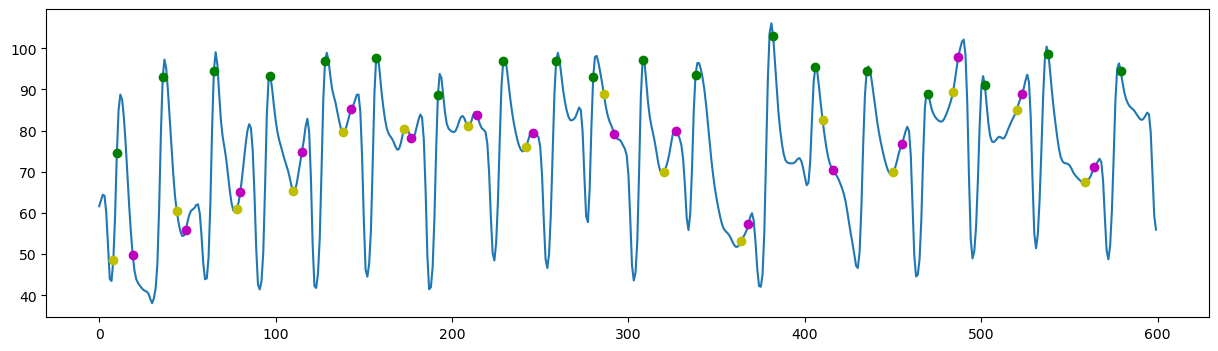

In [34]:
L1_stance = lightON.iloc[:,-6]
L1_diff = pd.DataFrame(np.diff(np.array(L1_stance.astype(int))))
L1_TD = L1_diff.index[L1_diff[0] ==1]
L1_LO = L1_diff.index[L1_diff[0] ==-1]
#plotting
plt.figure(figsize=(15,4))
plt.plot(L1_Ctr)
plt.plot(manual_L1,L1_Ctr.iloc[manual_L1] , 'o', color = 'g')
plt.plot(L1_TD,L1_Ctr.iloc[L1_TD] ,'o', color = 'm')
plt.plot(L1_LO,L1_Ctr.iloc[L1_LO] ,'o', color = 'y')
plt.show()

In [39]:
manual_R1_LO = [44, 78, 110, 139, 173, 200+ 10, 200+42, 200+86, 200+121, 200+164, 400+11, 400+ 50, 400+83, 400+120, 400+160]

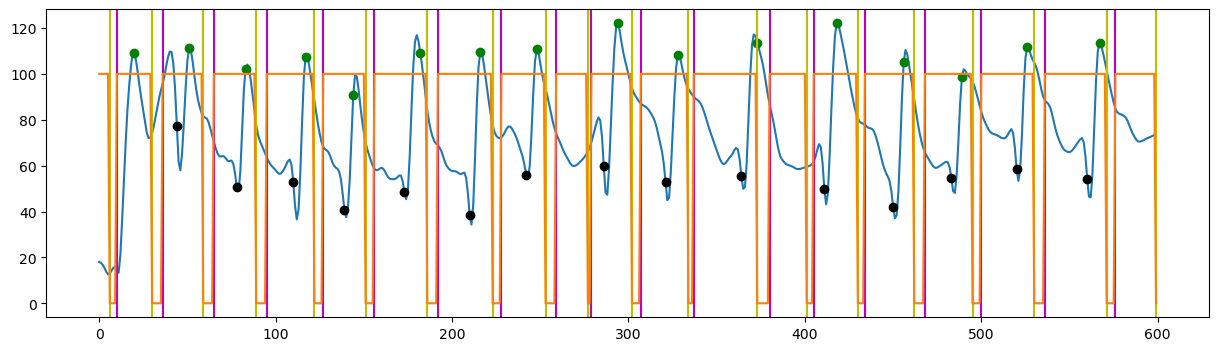

In [45]:
R1_stance = lightON.iloc[:,-3]
R1_diff = pd.DataFrame(np.diff(np.array(R1_stance.astype(int))))
R1_TD = R1_diff.index[R1_diff[0] ==1]
R1_LO = R1_diff.index[R1_diff[0] ==-1]
#plotting
plt.figure(figsize=(15,4))
plt.plot(R1_Ctr)
plt.plot(manual_R1,R1_Ctr.iloc[manual_R1] , 'o', color = 'g')
#plt.plot(R1_TD,R1_Ctr.iloc[R1_TD] ,'o', color = 'm')
for point in R1_TD:
    plt.axvline(x=point+1, color='m')
for point in R1_LO:
    plt.axvline(x=point+1, color='y')
plt.plot(manual_R1_LO,R1_Ctr.iloc[manual_R1_LO] , 'o', color = 'k')
plt.plot(R1_stance*100)
plt.show()

In [42]:
R1_stance

0       True
1       True
2       True
3       True
4       True
       ...  
595     True
596     True
597     True
598     True
599    False
Name: R1_stepcycle, Length: 600, dtype: bool

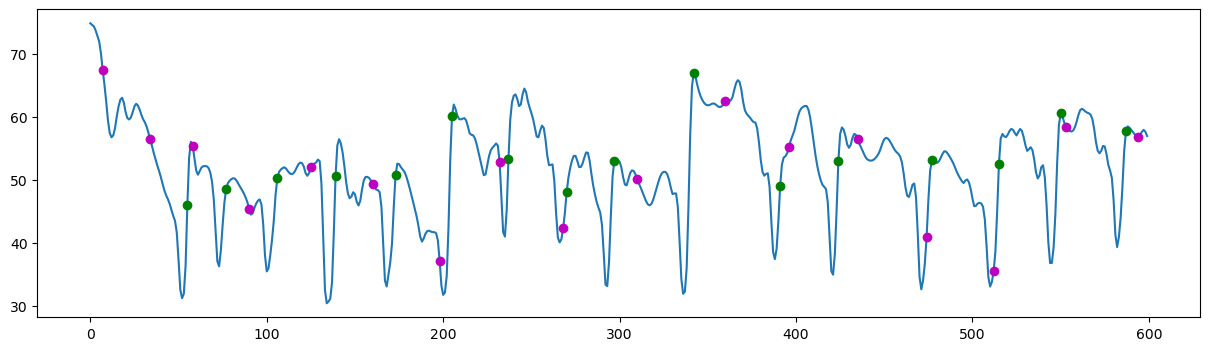

In [28]:
L2_stance = lightON.iloc[:,-5]
L2_diff = pd.DataFrame(np.diff(np.array(L2_stance.astype(int))))
L2_TD = L2_diff.index[L2_diff[0] ==1]
#plotting
plt.figure(figsize=(15,4))
plt.plot(L2_Ctr)
plt.plot(manual_L2,L2_Ctr.iloc[manual_L2] , 'o', color = 'g')
plt.plot(L2_TD,L2_Ctr.iloc[L2_TD] ,'o', color = 'm')
plt.show()

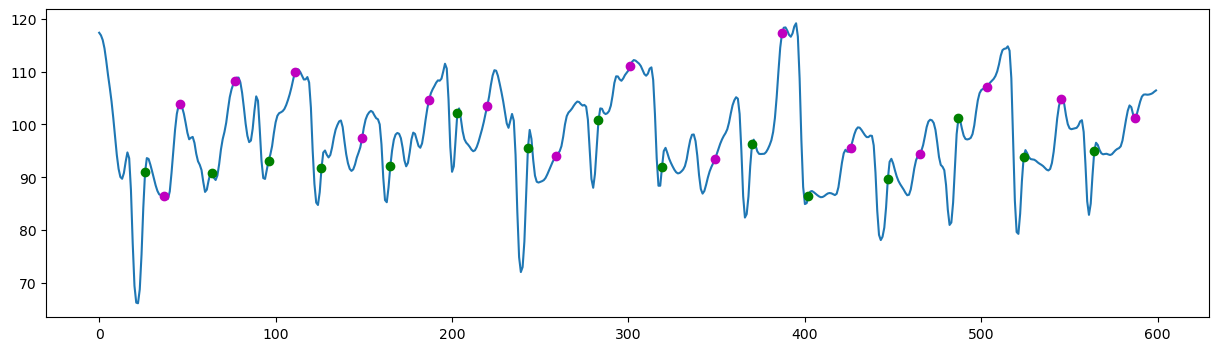

In [29]:
L3_stance = lightON.iloc[:,-4]
L3_diff = pd.DataFrame(np.diff(np.array(L3_stance.astype(int))))
L3_TD = L3_diff.index[L3_diff[0] ==1]
#plotting
plt.figure(figsize=(15,4))
plt.plot(L3_Ctr)
plt.plot(manual_L3,L3_Ctr.iloc[manual_L3] , 'o', color = 'g')
plt.plot(L3_TD,L3_Ctr.iloc[L3_TD] ,'o', color = 'm')
plt.show()

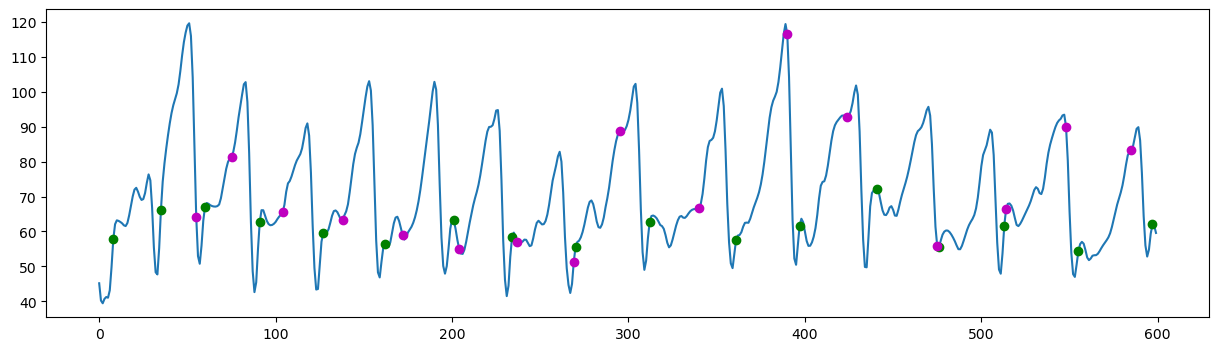

In [30]:
R2_stance = lightON.iloc[:,-2]
R2_diff = pd.DataFrame(np.diff(np.array(R2_stance.astype(int))))
R2_TD = R2_diff.index[R2_diff[0] ==1]
#plotting
plt.figure(figsize=(15,4))
plt.plot(R2_Ctr)
plt.plot(manual_R2,R2_Ctr.iloc[manual_R2] , 'o', color = 'g')
plt.plot(R2_TD,R2_Ctr.iloc[R2_TD] ,'o', color = 'm')
plt.show()

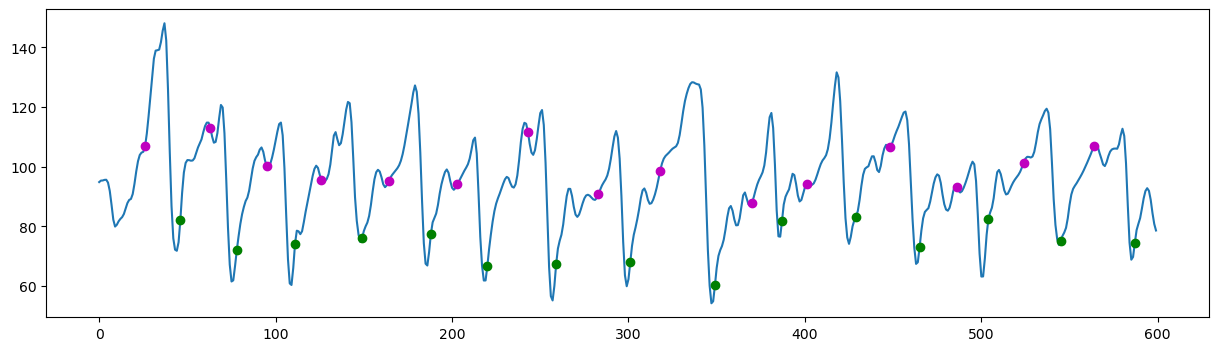

In [31]:
R3_stance = lightON.iloc[:,-1]
R3_diff = pd.DataFrame(np.diff(np.array(R3_stance.astype(int))))
R3_TD = R3_diff.index[R3_diff[0] ==1]
#plotting
plt.figure(figsize=(15,4))
plt.plot(R3_Ctr)
plt.plot(manual_R3,R3_Ctr.iloc[manual_R3] , 'o', color = 'g')
plt.plot(R3_TD,R3_Ctr.iloc[R3_TD] ,'o', color = 'm')
plt.show()